# Reconocimiento mediante Deep Neural Networks

OpenCV dispone de la extensión [**dnn**](https://docs.opencv.org/4.x/d2/d58/tutorial_table_of_content_dnn.html) con la que se pueden utilizar redes neuronales entrenadas con aprendizaje profundo para el procesado de imágenes. OpenCV no ofrece herramientas de entrenamiento sino que permite cargar la topología y pesos de redes neuronales entrenadas con destacadas aplicaciones de aprendizaje automático.

El proceso de empleo de una red neuronal consta de los siguientes pasos:
* Creación de una red neuronal cargando la topología y pesos desde ficheros.
* Conversión de la imagen en un formato adecuado para ser usada en la red neuronal.
* Establecer dicha imagen como entrada.
* Activar la propagación de las señales de las neuronas para obtener un resultado de salida.
* Interpretar los resultados obtenidos.

In [1]:
import cv2
import numpy as np
import cuia

## Creación de la red neuronal

El módulo dnn de OpenCV permite incorporar modelos de redes neuronales entrenadas con:
* [Caffe](http://caffe.berkeleyvision.org/)
* [TensorFlow](https://www.tensorflow.org/)
* [Torch](http://torch.ch/)
* [Darknet](https://pjreddie.com/darknet/)
* [OpenVINO](https://software.intel.com/openvino-toolkit)
* [ONNX](https://onnx.ai/)

La carga de la configuración de una red neuronal se hace mediante [**readNet**(framework, bufferModel, bufferConfig)](https://docs.opencv.org/4.x/d6/d0f/group__dnn.html#ga138439da76f26266fdefec9723f6c5cd)
* *framework* es el nombre del framework que se usó para crear la red
* *bufferModel* es contenido de un fichero binario donde se encuentran cargados los pesos de las conexiones de la red
* *bufferConfig* es el contenido de un fichero de texto que contiene la configuración de la red

El módulo dnn ofrece funciones sobrecargadas de readNet adaptadas a la lectura de redes neuronales entrenadas con frameworks específicos:
* [**readNetFromCaffe**](https://docs.opencv.org/4.x/d6/d0f/group__dnn.html#ga946b342af1355185a7107640f868b64a)
* [**readNetFromDarknet**](https://docs.opencv.org/4.x/d6/d0f/group__dnn.html#ga351c327837e9e2d98035487695f74836)
* [**readNetFromONNX**](https://docs.opencv.org/4.x/d6/d0f/group__dnn.html#ga9198ecaac7c32ddf0aa7a1bcbd359567)
* [**readNetFromTensorflow**](https://docs.opencv.org/4.x/d6/d0f/group__dnn.html#gacdba30a7c20db2788efbf5bb16a7884d)
* [**readNetFromTorch**](https://docs.opencv.org/4.x/d6/d0f/group__dnn.html#ga73785dd1e95cd3070ef36f3109b053fe)

Comenzaremos creando una red entrenada con Caffe

In [2]:
red = cv2.dnn.readNetFromCaffe("dnn/deploy.prototxt" , "dnn/res10_300x300_ssd_iter_140000.caffemodel")

## Conversión de la imagen de entrada

Tomemos una imagen que queremos usar como entrada a la red neuronal.

![Oscars](media/oscars.jpg "Oscars")

Cada red neuronal tiene un número determinado de neuronas de entrada y posiblemente requiera que la imagen adapte su contenido a los niveles de entrada adecuados. Esta información debe ser suministrada por los creadores de la red.

[**blobFromImage**(image, scalefactor, size, mean, swapRB, crop, ddepth)](https://docs.opencv.org/4.x/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7)
* image (imagen que se quiere adaptar para ser usada como entrada a la red)
* scalefactor (factor de escalado, por defecto 1)
* size (tamaño de la imagen de salida, por defecto iguial a la entrada)
* mean (valores escalares que se restan a los canales, indicados por los creadores de la red)
* swapRB (valor lógico que indica si se desean intercambiar los canales B y R, por defecto falso)
* crop (valor lógico que indica si la imagen será recortada en lugar de ser escalada, por defecto falso)
* ddepth (tipo de dato de salida, por defecto real de 32bits CV_32F)

La red que hemos cargado tiene una entrada de 300x300

In [3]:
oscars = cv2.imread("media/oscars.jpg")
imagen_entrada = cv2.dnn.blobFromImage(oscars, size=(300,300))

## Suministro de entrada y propagación de las señales

La imagen adaptada obtenida en el paso anterior se suministra como entrada mediante [**setInput**](https://docs.opencv.org/4.x/db/d30/classcv_1_1dnn_1_1Net.html#a5e74adacffd6aa53d56046581de7fcbd). A partir de ese momento se pueden propagar las señales de activación de las neuronas mediante una llamada al método [**forward**](https://docs.opencv.org/4.x/db/d30/classcv_1_1dnn_1_1Net.html#a98ed94cb6ef7063d3697259566da310b) que devuelve la salida de la red. Esta salida debe ser interpretada de acuerdo a las especificaciones de los creadores de la red.

In [4]:
red.setInput(imagen_entrada)
salida = red.forward()

## Interpretación de los resultados

La red utilizada devuelve un vector en que cada entrada contiene:
* id (índice numérico)
* is_face (valor lógico que indica si se ha detectado una cara)
* confidence (valor real de confianza en que lo detectado sea una cara)
* left, top, right, bottom (coordenadas de los lados del rectángulo que contiene la cara, expresadas como valores reales entre 0 y 1)

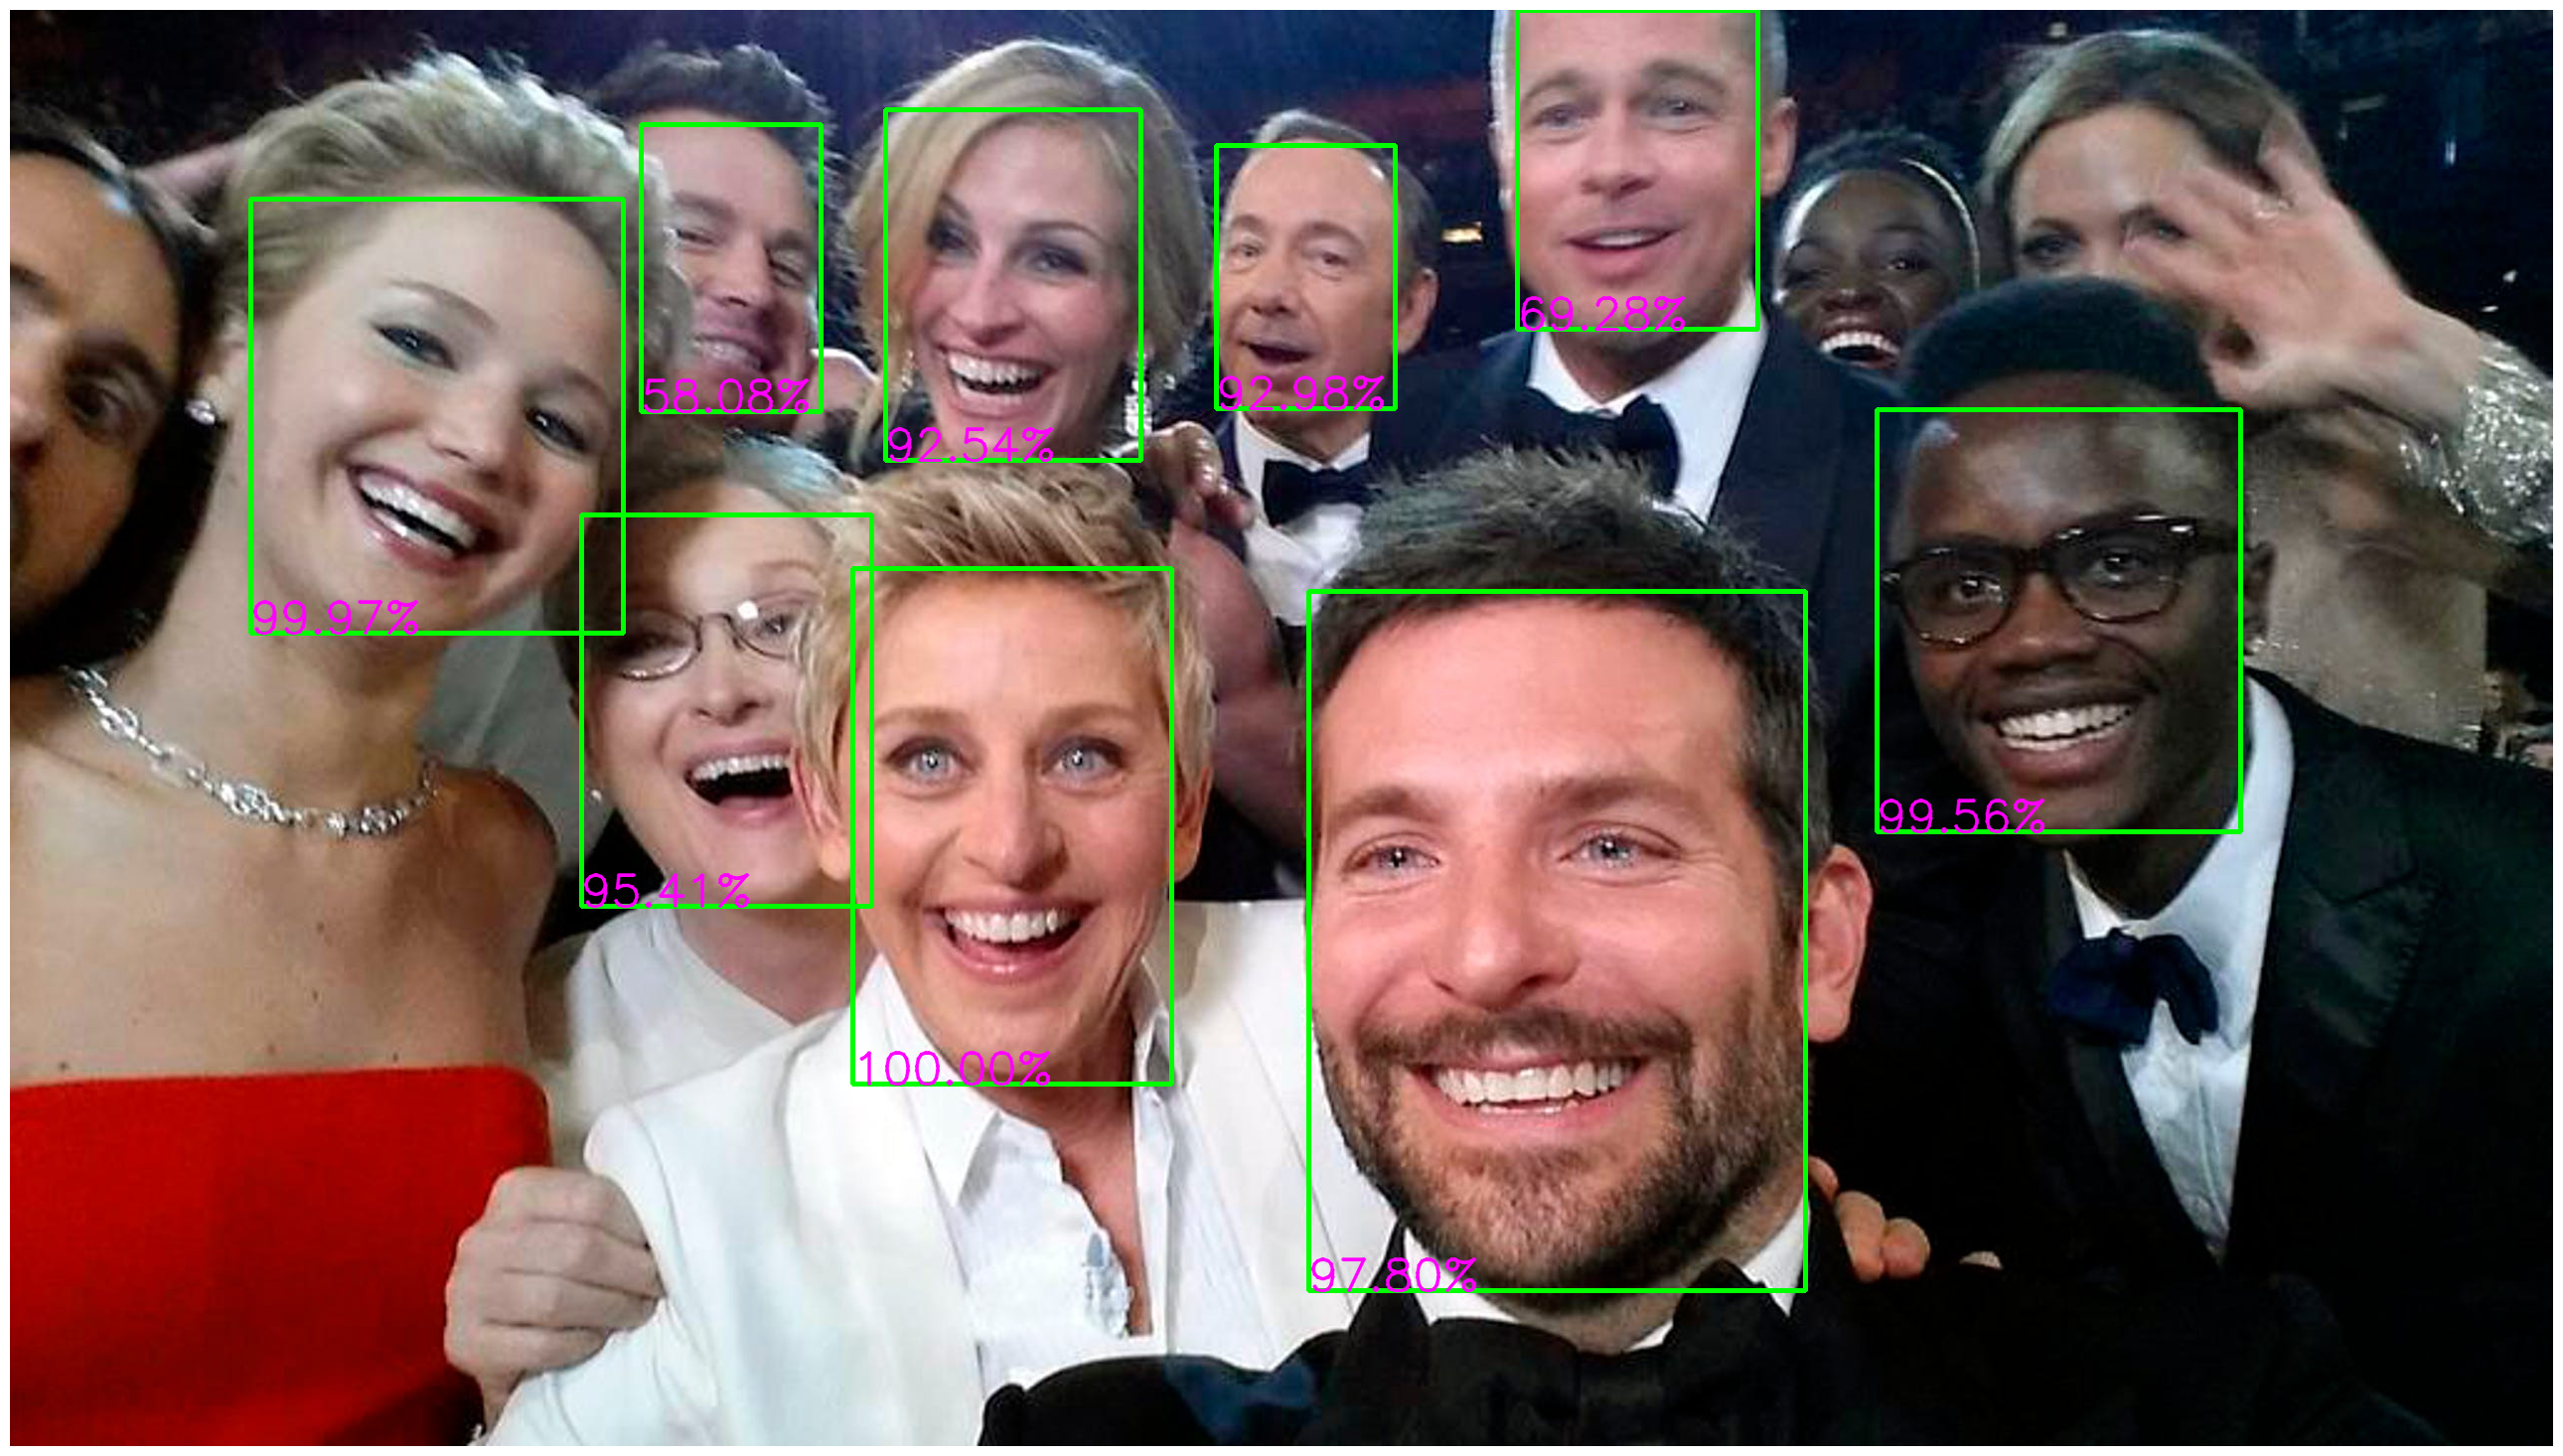

In [5]:
imagen = oscars.copy()
h, w, _ = imagen.shape
for cara in salida[0][0]:
    if cara[1] == 1 and cara[2]>0.5: #Vamos a resaltar las caras detectadas con una confianza superior a 0.5
        c1 = (int(w*cara[3]), int(h*cara[6]))
        c2 = (int(w*cara[5]), int(h*cara[4]))
        cv2.rectangle(imagen, c1, c2, (0,255,0),3)
        cv2.putText(imagen, f'{cara[2]*100:.2f}%', c1, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,255), 2, cv2.LINE_AA)
        
cuia.plot(imagen)

La red empleada sirve para el reconocimiento de caras, no sirve para la identificación. Podríamos usar cualquier otra red que usara las funcionalidades que necesitemos. OpenCV sin embargo ofrece un módulo derivado de dnn especializado en la detección de caras.

# FaceDetectorYN y FaceRecognizerSF

[**FaceDetectorYN**](https://docs.opencv.org/4.x/df/d20/classcv_1_1FaceDetectorYN.html) y [**FaceRecognizerSF**](https://docs.opencv.org/4.x/da/d09/classcv_1_1FaceRecognizerSF.html) son clases que incorporan [YuNet](https://github.com/ShiqiYu/libfacedetection) que son detectores e indentificadores de caras muy eficientes entrenados con ONNX. Las configuraciones de la red deben ser descargadas previamente de GitHub:
* FaceDetector - [https://github.com/opencv/opencv_zoo/tree/master/models/face_detection_yunet](https://github.com/opencv/opencv_zoo/tree/master/models/face_detection_yunet)
* FaceRecognizer - [https://github.com/opencv/opencv_zoo/tree/master/models/face_recognition_sface](https://github.com/opencv/opencv_zoo/tree/master/models/face_recognition_sface)

La detección de caras se realiza creando un objeto de tipo FaceDetectorYN con el método **create** para posteriormente hacer una llamada al método **detect**.

[**create**(model, config, input_size, score_threshold)](https://docs.opencv.org/4.x/df/d20/classcv_1_1FaceDetectorYN.html#aa0796a4bfe2d4709bef81abbae9a927a)
* model (fichero que contiene los pesos de la red previamente descargados)
* config (fichero que contiene la configuración, no es necesario ahora, se mantiene por compatibilidad)
* input_size (tamaño (ancho,alto) de las imágenes que se usarán como entrada a la red)
* score_threshold (puntuación mínima para las identificaciones positivas, por defecto 0.9)

[**detect**(image)](https://docs.opencv.org/4.x/df/d20/classcv_1_1FaceDetectorYN.html#ac05bd075ca3e6edc0e328927aae6f45b)
* image (imagen en la que se realizarán las deteccioones y cuyo tamaño debe coincidir con el que se especificó en **create**)

La detección devuelve un vector en que para cada cara detectada devuelve un vector de 15 números reales que indican:

| Posición | Descripción |
| :-: | :- |
| 0 | Coordenada x de la esquina superior izquierda del recuadro que delimita la cara |
| 1 | Coordenada y de la esquina superior izquierda del recuadro que delimita la cara |
| 2 | Ancho del recuadro |
| 3 | Alto del recuadro |
| 4 | Coordenada x del ojo derecho |
| 5 | Coordenada y del ojo derecho |
| 6 | Coordenada x del ojo izquierdo |
| 7 | Coordenada y del ojo izquierdo |
| 8 | Coordenada x de la punta de la nariz |
| 9 | Coordenada y de la punta de la nariz |
| 10 | Coordenada x del extremo derecho de la boca |
| 11 | Coordenada y del extremo derecho de la boca |
| 12 | Coordenada x del extremo izquierdo de la boca |
| 13 | Coordenada y del extremo izquierdo de la boca |
| 14 | Puntuación [0,1] de la cara

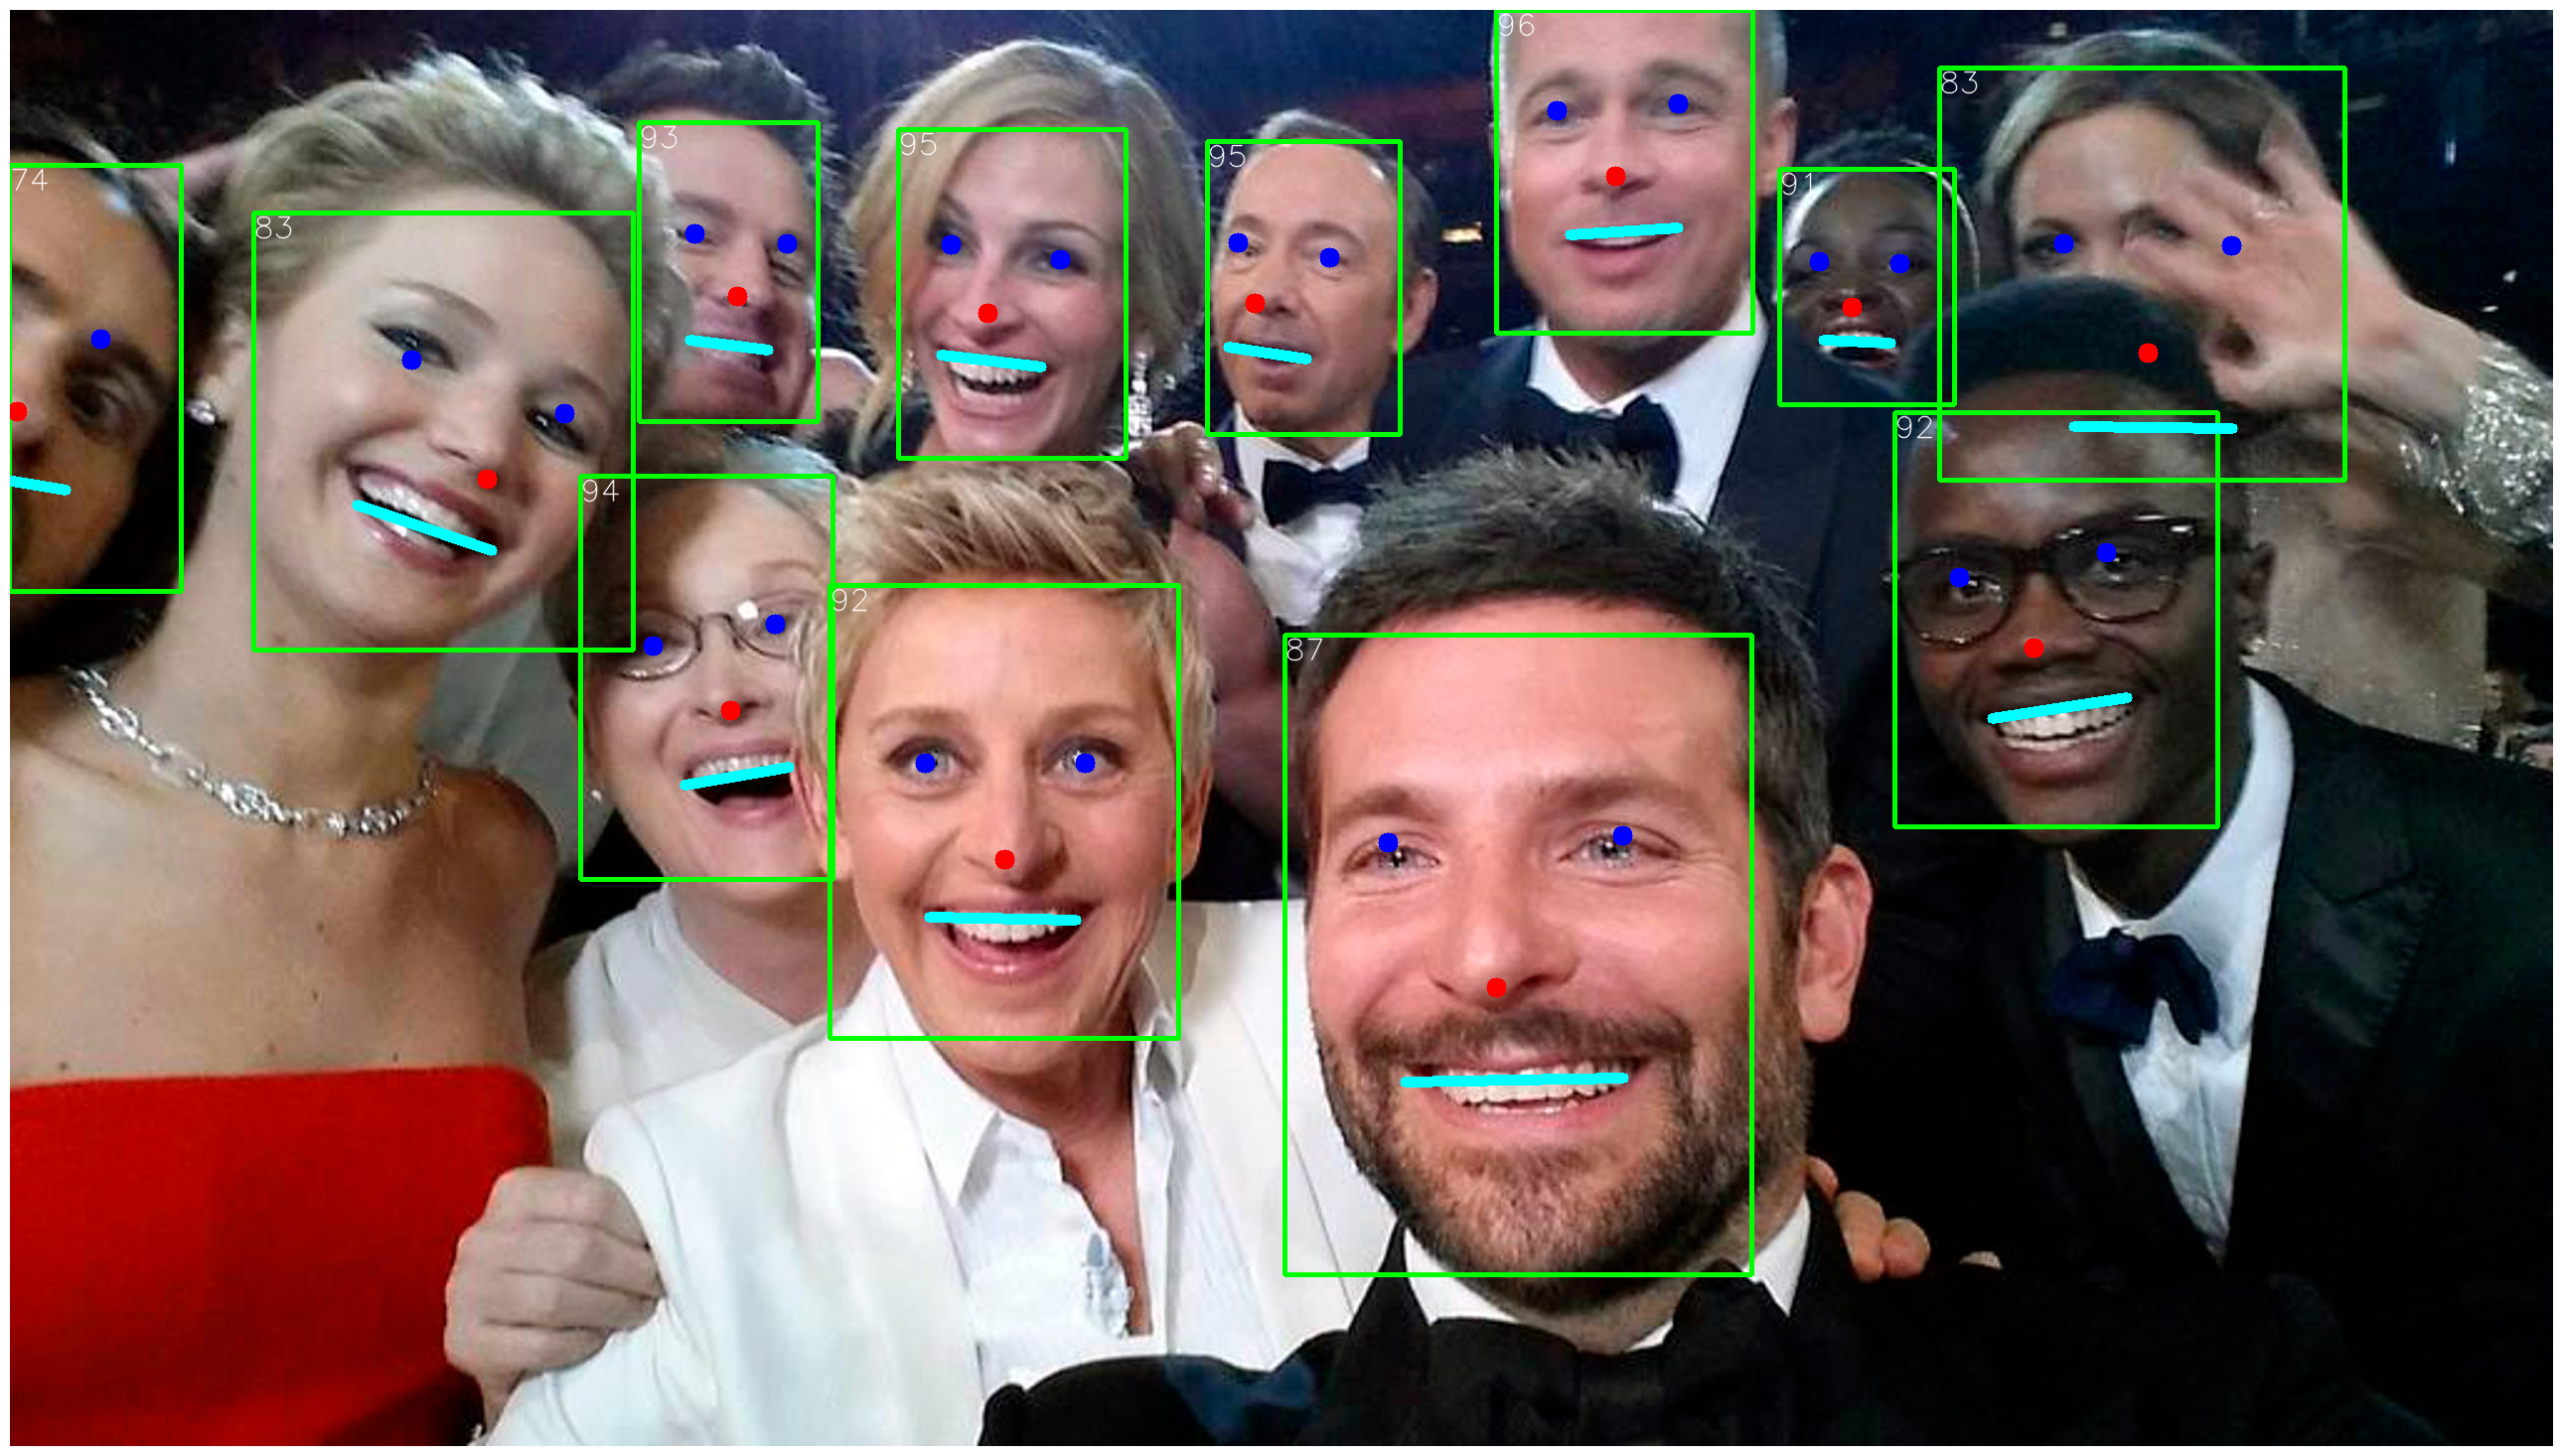

In [35]:
h, w, _ = oscars.shape
detector = cv2.FaceDetectorYN.create("dnn/face_detection_yunet_2023mar.onnx", config="", input_size=(w,h),  score_threshold=0.7)
ret, caras = detector.detect(oscars)
imagen = oscars.copy()
if ret:
    for cara in caras:
        c = cara.astype(int)
        cv2.rectangle(imagen, (c[0],c[1]), (c[0]+c[2],c[1]+c[3]), (0,255,0), 3)
        cv2.circle(imagen, (c[4],c[5]), 10, (255,0,0), -1)
        cv2.circle(imagen, (c[6],c[7]), 10, (255,0,0), -1)
        cv2.circle(imagen, (c[8],c[9]), 10, (0,0,255), -1)
        cv2.line(imagen, (c[10],c[11]), (c[12],c[13]), (255,255,0), 10)
        cv2.putText(imagen, str(round(100*cara[14])), (c[0],c[1]+25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)
cuia.plot(imagen)